In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models
from torchvision.models import DenseNet121_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import time
from tqdm import tqdm
import glob


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 1.0, gamma: float = 2.0, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [4]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        return (-weight * log_prob).sum(dim=-1).mean()


In [5]:
class MixUpAugmentation:
    def __init__(self, alpha: float = 1.0):
        self.alpha = alpha

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
        lam = np.random.beta(self.alpha, self.alpha) if self.alpha > 0 else 1
        index = torch.randperm(x.size(0)).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        return mixed_x, y, y[index], lam


In [6]:
class BreakHisDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], transform: Optional[transforms.Compose] = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception:
            image = Image.new('RGB', (299, 299), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [7]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes: int = 2, dropout_rate: float = 0.5):
        super().__init__()
        self.backbone = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

    def freeze_backbone(self):
        for name, param in self.backbone.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False


In [8]:
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs: int, base_lr: float):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.current_epoch = 0

    def step(self):
        if self.current_epoch < self.warmup_epochs:
            lr = self.base_lr * (self.current_epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_epoch += 1

In [9]:
class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 0.001, mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score: float):
        if self.best_score is None:
            self.best_score = val_score
        elif self.mode == 'min':
            if val_score < self.best_score - self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        else:
            if val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True

In [10]:
class MetricsCalculator:
    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1 = f1_score(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        }

    @staticmethod
    def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix"):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()


In [22]:
class BreakHisTrainer:
    """Main trainer class for BreakHis dataset."""

    def __init__(self, data_dir: str, batch_size: int = 32,
                 num_workers: int = 4, device: str = 'cuda',
                 use_mixup: bool = True, use_focal_loss: bool = True):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.use_mixup = use_mixup
        self.use_focal_loss = use_focal_loss

        print(f"Using device: {self.device}")

        # Results storage
        self.results = {}

        # Initialize Mixup if enabled
        if self.use_mixup:
            self.mixup = MixUpAugmentation(alpha=1.0)

        # Enhanced data transforms
        self.train_transforms = transforms.Compose([
            transforms.Resize((342, 342)),
            transforms.CenterCrop(299),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05),
                                  scale=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize((342, 342)),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def find_dataset_structure(self) -> str:
        """Find the correct dataset structure."""
        print(f"Searching for dataset in: {self.data_dir}")

        # Check if the directory exists
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Dataset directory does not exist: {self.data_dir}")

        # List all files and directories
        print("Directory contents:")
        for item in self.data_dir.iterdir():
            print(f"  {item}")

        # Try different possible patterns
        patterns = [
            "**/*.png",
            "**/*.PNG",
            "**/*.jpg",
            "**/*.JPG",
            "**/*.jpeg",
            "**/*.JPEG"
        ]

        for pattern in patterns:
            files = list(self.data_dir.glob(pattern))
            if files:
                print(f"Found {len(files)} files with pattern: {pattern}")
                return pattern

        raise FileNotFoundError(f"No image files found in {self.data_dir}")

    def parse_dataset(self) -> Dict[str, List]:
        """Parse BreakHis dataset structure with improved path handling."""
        print("🔍 Parsing BreakHis dataset...")

        # Find the correct file pattern
        pattern = self.find_dataset_structure()
        image_paths = list(self.data_dir.glob(pattern))

        print(f"📁 Found {len(image_paths)} image files")

        data_info = {
            'image_paths': [],
            'labels': [],
            'magnifications': [],
            'patient_ids': []
        }

        benign_count = 0
        malignant_count = 0

        for img_path in image_paths:
            try:
                img_path_str = str(img_path).lower()
                filename = img_path.name.lower()

                # First, check for malignant indicators
                if 'sob_m_' in filename or 'malignant' in img_path_str or '_m_' in filename:
                    label = 1
                    malignant_count += 1
                elif 'sob_b_' in filename or 'benign' in img_path_str or '_b_' in filename:
                    label = 0
                    benign_count += 1
                else:
                    # If uncertain, skip
                    continue

                # Extract magnification
                magnification = 'Unknown'
                for mag in ['40X', '100X', '200X', '400X']:
                    if mag.lower() in filename or f"-{mag[:-1]}-" in filename:
                        magnification = mag
                        break

                # Extract patient ID
                if 'sob_' in filename:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        patient_id = '-'.join(parts[:3])
                    else:
                        patient_id = filename.split('.')[0]
                else:
                    patient_id = filename.split('.')[0]

                data_info['image_paths'].append(str(img_path))
                data_info['labels'].append(label)
                data_info['magnifications'].append(magnification)
                data_info['patient_ids'].append(patient_id)

            except Exception as e:
                print(f"⚠️ Error processing {img_path}: {e}")
                continue

        print(f"✅ Successfully parsed {len(data_info['image_paths'])} images")
        print(f"📊 Benign: {benign_count}")
        print(f"📊 Malignant: {malignant_count}")
        print(f"🔍 Magnifications found: {set(data_info['magnifications'])}")
        print(f"👥 Unique patients: {len(set(data_info['patient_ids']))}")

        if len(data_info['image_paths']) == 0:
            raise ValueError("No valid images found! Check dataset structure and naming convention.")

        return data_info


    def create_patient_splits(self, data_info: Dict, test_size: float = 0.2,
                            val_size: float = 0.2) -> Dict[str, Dict]:
        """Create patient-level train/val/test splits."""
        print("📊 Creating patient-level splits...")

        df = pd.DataFrame(data_info)

        # Handle cases where patient IDs might not be unique across labels
        patient_labels = df.groupby('patient_ids')['labels'].agg(lambda x: x.mode()[0]).reset_index()

        # Check if we have both classes
        unique_labels = patient_labels['labels'].unique()
        if len(unique_labels) < 2:
            print("⚠️ Warning: Only one class found. Using random splits.")
            # Random splits without stratification
            all_patients = patient_labels['patient_ids'].tolist()
            train_val_patients, test_patients = train_test_split(
                all_patients, test_size=test_size, random_state=42
            )
            train_patients, val_patients = train_test_split(
                train_val_patients, test_size=val_size/(1-test_size), random_state=42
            )
        else:
            # Stratified splits
            train_val_patients, test_patients = train_test_split(
                patient_labels['patient_ids'].tolist(),
                test_size=test_size,
                stratify=patient_labels['labels'].tolist(),
                random_state=42
            )

            train_val_labels = patient_labels[
                patient_labels['patient_ids'].isin(train_val_patients)
            ]['labels'].tolist()

            train_patients, val_patients = train_test_split(
                train_val_patients,
                test_size=val_size / (1 - test_size),
                stratify=train_val_labels,
                random_state=42
            )

        # Create splits for each magnification
        magnifications = list(set(data_info['magnifications'])) + ['All']
        splits = {}

        for mag in magnifications:
            if mag == 'All':
                mag_mask = pd.Series([True] * len(df))
            else:
                mag_mask = df['magnifications'] == mag

            mag_df = df[mag_mask]

            if len(mag_df) == 0:
                continue

            train_mask = mag_df['patient_ids'].isin(train_patients)
            val_mask = mag_df['patient_ids'].isin(val_patients)
            test_mask = mag_df['patient_ids'].isin(test_patients)

            splits[mag] = {
                'train': {
                    'image_paths': mag_df[train_mask]['image_paths'].tolist(),
                    'labels': mag_df[train_mask]['labels'].tolist()
                },
                'val': {
                    'image_paths': mag_df[val_mask]['image_paths'].tolist(),
                    'labels': mag_df[val_mask]['labels'].tolist()
                },
                'test': {
                    'image_paths': mag_df[test_mask]['image_paths'].tolist(),
                    'labels': mag_df[test_mask]['labels'].tolist()
                }
            }

            print(f"\n{mag} - Train: {len(splits[mag]['train']['labels'])}, "
                  f"Val: {len(splits[mag]['val']['labels'])}, "
                  f"Test: {len(splits[mag]['test']['labels'])}")

        return splits

    def create_data_loaders(self, splits: Dict, magnification: str) -> Dict[str, DataLoader]:
        """Create data loaders for a specific magnification."""

        if magnification not in splits:
            raise ValueError(f"Magnification {magnification} not found in splits")

        split_data = splits[magnification]

        # Create datasets
        train_dataset = BreakHisDataset(
            split_data['train']['image_paths'],
            split_data['train']['labels'],
            self.train_transforms
        )

        val_dataset = BreakHisDataset(
            split_data['val']['image_paths'],
            split_data['val']['labels'],
            self.val_transforms
        )

        test_dataset = BreakHisDataset(
            split_data['test']['image_paths'],
            split_data['test']['labels'],
            self.val_transforms
        )

        # Handle class imbalance with weighted sampling if we have both classes
        train_labels = split_data['train']['labels']
        unique_labels = list(set(train_labels))

        if len(unique_labels) > 1:
            class_weights = compute_class_weight(
                'balanced',
                classes=np.array(unique_labels),
                y=train_labels
            )

            # Create a mapping from label to weight
            label_to_weight = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
            sample_weights = [label_to_weight[label] for label in train_labels]

            sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights),
                replacement=True
            )
        else:
            sampler = None

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            sampler=sampler,
            shuffle=(sampler is None),
            num_workers=self.num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        return {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }

    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        """Mixup loss calculation."""
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   criterion: nn.Module, optimizer: torch.optim.Optimizer) -> float:
        """Train for one epoch with optional Mixup."""
        model.train()
        total_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()

            if self.use_mixup and np.random.rand() > 0.5:
                mixed_images, y_a, y_b, lam = self.mixup(images, labels)
                outputs = model(mixed_images)
                loss = self.mixup_criterion(criterion, outputs, y_a, y_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self, model: nn.Module, val_loader: DataLoader,
                      criterion: nn.Module) -> Tuple[float, float]:
        """Validate for one epoch."""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

        avg_loss = total_loss / len(val_loader)

        # Calculate AUC only if we have both classes
        if len(set(all_labels)) > 1:
            auc_roc = roc_auc_score(all_labels, all_probs)
        else:
            auc_roc = 0.0

        return avg_loss, auc_roc

    def test_model(self, model: nn.Module, test_loader: DataLoader,
                   use_tta: bool = True) -> Dict[str, float]:
        """Test the model with optional Test Time Augmentation."""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)

                if use_tta:
                    # Simple TTA: original + horizontal flip
                    outputs1 = model(images)
                    outputs2 = model(torch.flip(images, dims=[3]))
                    outputs = (outputs1 + outputs2) / 2
                else:
                    outputs = model(images)

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

        return MetricsCalculator.calculate_metrics(
            np.array(all_labels),
            np.array(all_preds),
            np.array(all_probs)
        )

    def train_magnification(self, splits: Dict, magnification: str,
                          epochs: int = 100) -> Dict[str, float]:
        """Train model for a specific magnification."""

        print(f"\n{'='*60}")
        print(f"🔬 Training on {magnification} magnification")
        print(f"🧬 Using Mixup: {self.use_mixup}, Focal Loss: {self.use_focal_loss}")
        print(f"{'='*60}")

        # Create data loaders
        try:
            data_loaders = self.create_data_loaders(splits, magnification)
        except ValueError as e:
            print(f"❌ Error creating data loaders: {e}")
            return {}

        # Check if we have enough data
        if len(data_loaders['train']) == 0:
            print(f"⚠️ No training data for {magnification}")
            return {}

        # Initialize model
        model = TumorClassifier(num_classes=2, dropout_rate=0.3)
        model.to(self.device)

        # Loss function
        if self.use_focal_loss:
            criterion = FocalLoss(alpha=1.0, gamma=2.0)
        else:
            criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

        # Training setup
        model.freeze_backbone()

        base_lr = 0.001
        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=base_lr, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=10, verbose=True)
        early_stopping = EarlyStopping(patience=15, mode='max')

        best_auc = 0.0
        best_model_state = None

        # Training loop
        for epoch in range(epochs):
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

        # Load best model and test
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        test_metrics = self.test_model(model, data_loaders['test'], use_tta=True)

        print(f"\n🎯 Best validation AUC: {best_auc:.4f}")
        print(f"📊Test Metrics for {magnification} magnification:")
        for metric, value in test_metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric.capitalize()}: {value:.4f}")

        # Plot confusion matrix
        MetricsCalculator.plot_confusion_matrix(test_metrics['confusion_matrix'],
                                                title=f"{magnification} Confusion Matrix")

        # Store result
        self.results[magnification] = test_metrics
        return test_metrics



In [23]:
def run_all_experiments(self, data_dir):
    data_info = self.parse_dataset()
    splits = self.create_patient_splits(data_info)
    results = {}

    for mag in ['40X', '100X', '200X', '400X', 'All']:
        try:
            metrics = self.train_magnification(splits, magnification=mag, epochs=50)
            if metrics:
                results[mag] = metrics
        except Exception as e:
            print(f"⚠️ Error with {mag}: {e}")
            continue

    df = pd.DataFrame([{'Magnification': mag, **metrics} for mag, metrics in results.items()]) if results else pd.DataFrame()
    self.results = results
    return df

BreakHisTrainer.run_all_experiments = run_all_experiments


In [24]:
def main():
    """Main function to run the experiments."""
    import kagglehub

    # Download dataset
    path = kagglehub.dataset_download("ambarish/breakhis")
    print("Path to dataset files:", path)

    # ✅ Corrected subdirectory path
    DATA_DIR = os.path.join(path, "BreaKHis_v1", "BreaKHis_v1", "histology_slides", "breast")

    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")
    print("Using Inception-v3 backbone")

    # Initialize trainer
    trainer = BreakHisTrainer(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Run all experiments
    results_df = trainer.run_all_experiments(DATA_DIR)

    # Save results
    if not results_df.empty:
        results_df.to_csv('breakhis_inception_v3_results.csv', index=False)
        print("\n✅ Results saved to 'breakhis_inception_v3_results.csv'")

        # Summary
        print("\n" + "="*80)
        print("📈 EXPERIMENT SUMMARY - Inception-v3")
        print("="*80)
        print(f"Average Accuracy: {results_df['accuracy'].mean():.4f}")
        print(f"Average AUC-ROC: {results_df['auc_roc'].mean():.4f}")
        print(f"Best magnification: {results_df.loc[results_df['accuracy'].idxmax(), 'Magnification']}")
    else:
        print("❌ No results were generated.")

    return results_df


Path to dataset files: /kaggle/input/breakhis
Using device: cuda
Using Inception-v3 backbone
Using device: cuda
🔍 Parsing BreakHis dataset...
Searching for dataset in: /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast
Directory contents:
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant
Found 7909 files with pattern: **/*.png
📁 Found 7909 image files
✅ Successfully parsed 7909 images
📊 Benign: 2480
📊 Malignant: 5429
🔍 Magnifications found: {'40X', '100X', '400X', '200X'}
👥 Unique patients: 82
📊 Creating patient-level splits...

40X - Train: 1172, Val: 382, Test: 441

100X - Train: 1201, Val: 403, Test: 477

400X - Train: 1059, Val: 367, Test: 394

200X - Train: 1188, Val: 382, Test: 44

Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch   1: Train Loss: 0.1507, Val Loss: 0.1324, Val AUC: 0.8314


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch   2: Train Loss: 0.1294, Val Loss: 0.1962, Val AUC: 0.7595


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch   3: Train Loss: 0.1244, Val Loss: 0.1772, Val AUC: 0.7920


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   4: Train Loss: 0.1237, Val Loss: 0.1297, Val AUC: 0.8759


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch   5: Train Loss: 0.1146, Val Loss: 0.1089, Val AUC: 0.8958


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch   6: Train Loss: 0.1162, Val Loss: 0.1316, Val AUC: 0.8843


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch   7: Train Loss: 0.1176, Val Loss: 0.1465, Val AUC: 0.8289


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch   8: Train Loss: 0.1115, Val Loss: 0.1491, Val AUC: 0.8111


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   9: Train Loss: 0.1166, Val Loss: 0.1551, Val AUC: 0.8671


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  10: Train Loss: 0.1095, Val Loss: 0.1407, Val AUC: 0.8533


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  11: Train Loss: 0.1229, Val Loss: 0.1291, Val AUC: 0.8737


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  12: Train Loss: 0.1120, Val Loss: 0.1264, Val AUC: 0.8842


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Epoch  13: Train Loss: 0.1016, Val Loss: 0.1574, Val AUC: 0.8479


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Epoch  14: Train Loss: 0.1177, Val Loss: 0.1099, Val AUC: 0.8889


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  15: Train Loss: 0.1119, Val Loss: 0.1348, Val AUC: 0.8937


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch  16: Train Loss: 0.1103, Val Loss: 0.1325, Val AUC: 0.8668


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  17: Train Loss: 0.1110, Val Loss: 0.1025, Val AUC: 0.9128


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  18: Train Loss: 0.1026, Val Loss: 0.0974, Val AUC: 0.9297


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  19: Train Loss: 0.1014, Val Loss: 0.1277, Val AUC: 0.8836


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  20: Train Loss: 0.1064, Val Loss: 0.1259, Val AUC: 0.8556


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  21: Train Loss: 0.1006, Val Loss: 0.1102, Val AUC: 0.8962


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  22: Train Loss: 0.1075, Val Loss: 0.1121, Val AUC: 0.8829


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch  23: Train Loss: 0.1012, Val Loss: 0.1205, Val AUC: 0.8865


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  24: Train Loss: 0.0994, Val Loss: 0.0950, Val AUC: 0.8969


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch  25: Train Loss: 0.0982, Val Loss: 0.1041, Val AUC: 0.9115


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  26: Train Loss: 0.1003, Val Loss: 0.1222, Val AUC: 0.8597


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch  27: Train Loss: 0.1103, Val Loss: 0.1150, Val AUC: 0.8882


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch  28: Train Loss: 0.0906, Val Loss: 0.1087, Val AUC: 0.8922


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  29: Train Loss: 0.1111, Val Loss: 0.1088, Val AUC: 0.8784


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  30: Train Loss: 0.0928, Val Loss: 0.1199, Val AUC: 0.8767


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch  31: Train Loss: 0.1087, Val Loss: 0.1284, Val AUC: 0.8548


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch  32: Train Loss: 0.1046, Val Loss: 0.1220, Val AUC: 0.8689


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch  33: Train Loss: 0.1074, Val Loss: 0.1284, Val AUC: 0.8522
⏹️ Early stopping at epoch 33


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]



🎯 Best validation AUC: 0.9297
📊Test Metrics for 40X magnification:
  Accuracy: 0.8186
  Precision: 0.9202
  Recall: 0.7568
  Specificity: 0.9066
  F1: 0.8305
  Auc_roc: 0.8922


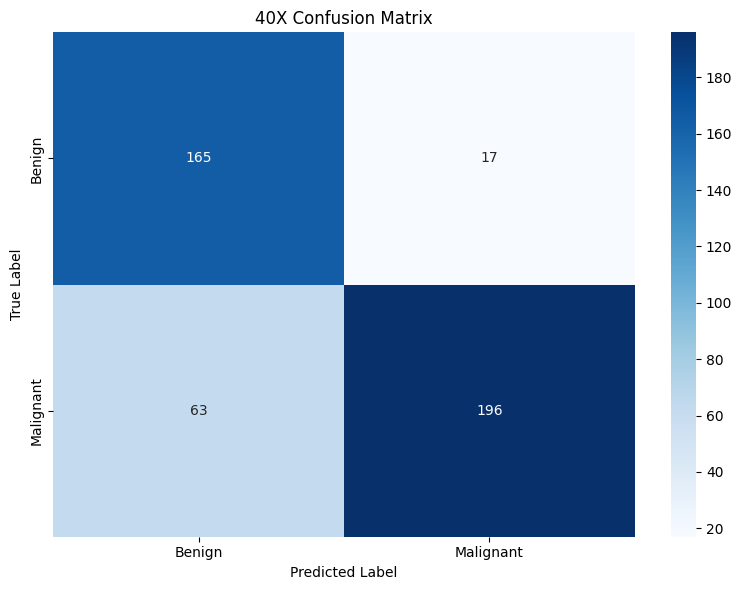


🔬 Training on 100X magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch   1: Train Loss: 0.1428, Val Loss: 0.1317, Val AUC: 0.8847


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch   2: Train Loss: 0.1333, Val Loss: 0.1450, Val AUC: 0.8705


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch   3: Train Loss: 0.1263, Val Loss: 0.1578, Val AUC: 0.8028


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch   4: Train Loss: 0.1322, Val Loss: 0.1289, Val AUC: 0.8666


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch   5: Train Loss: 0.1200, Val Loss: 0.1673, Val AUC: 0.8273


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch   6: Train Loss: 0.1195, Val Loss: 0.1395, Val AUC: 0.8557


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch   7: Train Loss: 0.1290, Val Loss: 0.1486, Val AUC: 0.7986


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch   8: Train Loss: 0.1224, Val Loss: 0.1319, Val AUC: 0.8650


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch   9: Train Loss: 0.1042, Val Loss: 0.1358, Val AUC: 0.8705


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch  10: Train Loss: 0.1247, Val Loss: 0.1297, Val AUC: 0.8570


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch  11: Train Loss: 0.1066, Val Loss: 0.1046, Val AUC: 0.8965


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch  12: Train Loss: 0.1185, Val Loss: 0.1210, Val AUC: 0.8672


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch  13: Train Loss: 0.1170, Val Loss: 0.1333, Val AUC: 0.8733


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


Epoch  14: Train Loss: 0.1211, Val Loss: 0.1192, Val AUC: 0.9043


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch  15: Train Loss: 0.1145, Val Loss: 0.1274, Val AUC: 0.8617


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Epoch  16: Train Loss: 0.1195, Val Loss: 0.1289, Val AUC: 0.8861


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch  17: Train Loss: 0.1018, Val Loss: 0.1225, Val AUC: 0.8980


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch  18: Train Loss: 0.1095, Val Loss: 0.1337, Val AUC: 0.8572


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


Epoch  19: Train Loss: 0.1060, Val Loss: 0.1140, Val AUC: 0.8824


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch  20: Train Loss: 0.1058, Val Loss: 0.1274, Val AUC: 0.8409


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch  21: Train Loss: 0.1144, Val Loss: 0.1133, Val AUC: 0.8854


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch  22: Train Loss: 0.1158, Val Loss: 0.1067, Val AUC: 0.8954


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Epoch  23: Train Loss: 0.1245, Val Loss: 0.1439, Val AUC: 0.8290


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch  24: Train Loss: 0.1065, Val Loss: 0.1172, Val AUC: 0.8940


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch  25: Train Loss: 0.1245, Val Loss: 0.1161, Val AUC: 0.8760


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch  26: Train Loss: 0.1198, Val Loss: 0.1269, Val AUC: 0.8550


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch  27: Train Loss: 0.1075, Val Loss: 0.1343, Val AUC: 0.8562


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


Epoch  28: Train Loss: 0.1097, Val Loss: 0.1307, Val AUC: 0.8521


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Epoch  29: Train Loss: 0.1068, Val Loss: 0.1282, Val AUC: 0.8712
⏹️ Early stopping at epoch 29


Testing: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]



🎯 Best validation AUC: 0.9043
📊Test Metrics for 100X magnification:
  Accuracy: 0.8176
  Precision: 0.9688
  Recall: 0.7306
  Specificity: 0.9611
  F1: 0.8330
  Auc_roc: 0.9040


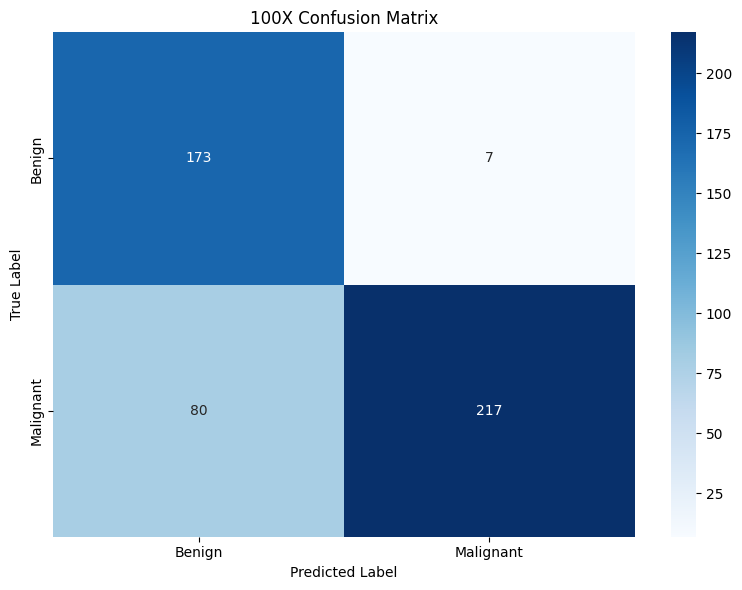


🔬 Training on 200X magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Epoch   1: Train Loss: 0.1418, Val Loss: 0.1142, Val AUC: 0.8415


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch   2: Train Loss: 0.1200, Val Loss: 0.1116, Val AUC: 0.8570


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch   3: Train Loss: 0.1194, Val Loss: 0.1132, Val AUC: 0.8612


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch   4: Train Loss: 0.1088, Val Loss: 0.1258, Val AUC: 0.8319


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch   5: Train Loss: 0.1236, Val Loss: 0.0959, Val AUC: 0.9064


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch   6: Train Loss: 0.1290, Val Loss: 0.1031, Val AUC: 0.8678


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   7: Train Loss: 0.1180, Val Loss: 0.1092, Val AUC: 0.8694


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch   8: Train Loss: 0.1130, Val Loss: 0.1152, Val AUC: 0.8469


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch   9: Train Loss: 0.1198, Val Loss: 0.1267, Val AUC: 0.8190


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch  10: Train Loss: 0.1218, Val Loss: 0.1000, Val AUC: 0.9024


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch  11: Train Loss: 0.1221, Val Loss: 0.1202, Val AUC: 0.8191


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  12: Train Loss: 0.1151, Val Loss: 0.1067, Val AUC: 0.8825


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch  13: Train Loss: 0.1192, Val Loss: 0.1375, Val AUC: 0.8370


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  14: Train Loss: 0.1173, Val Loss: 0.1134, Val AUC: 0.8599


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  15: Train Loss: 0.1131, Val Loss: 0.1092, Val AUC: 0.8621


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  16: Train Loss: 0.1295, Val Loss: 0.1148, Val AUC: 0.8519


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  17: Train Loss: 0.1171, Val Loss: 0.1111, Val AUC: 0.8509


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  18: Train Loss: 0.1013, Val Loss: 0.1045, Val AUC: 0.8677


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch  19: Train Loss: 0.1061, Val Loss: 0.1046, Val AUC: 0.8691


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  20: Train Loss: 0.1006, Val Loss: 0.1112, Val AUC: 0.8501
⏹️ Early stopping at epoch 20


Testing: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]



🎯 Best validation AUC: 0.9064
📊Test Metrics for 200X magnification:
  Accuracy: 0.8555
  Precision: 0.8973
  Recall: 0.8645
  Specificity: 0.8412
  F1: 0.8806
  Auc_roc: 0.9262


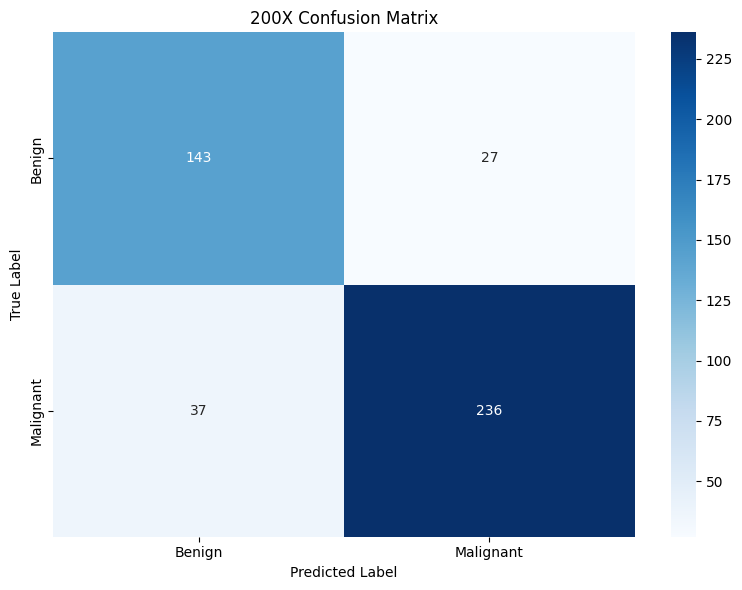


🔬 Training on 400X magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch   1: Train Loss: 0.1555, Val Loss: 0.1209, Val AUC: 0.8638


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch   2: Train Loss: 0.1496, Val Loss: 0.1132, Val AUC: 0.9095


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch   3: Train Loss: 0.1384, Val Loss: 0.1333, Val AUC: 0.8723


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch   4: Train Loss: 0.1343, Val Loss: 0.1159, Val AUC: 0.8638


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch   5: Train Loss: 0.1251, Val Loss: 0.1369, Val AUC: 0.8538


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch   6: Train Loss: 0.1204, Val Loss: 0.1086, Val AUC: 0.9139


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch   7: Train Loss: 0.1305, Val Loss: 0.1321, Val AUC: 0.8773


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   8: Train Loss: 0.1257, Val Loss: 0.1297, Val AUC: 0.8962


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   9: Train Loss: 0.1338, Val Loss: 0.1429, Val AUC: 0.8509


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch  10: Train Loss: 0.1235, Val Loss: 0.1484, Val AUC: 0.8787


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch  11: Train Loss: 0.1199, Val Loss: 0.1109, Val AUC: 0.8966


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch  12: Train Loss: 0.1222, Val Loss: 0.1220, Val AUC: 0.8983


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch  13: Train Loss: 0.1277, Val Loss: 0.1297, Val AUC: 0.8622


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch  14: Train Loss: 0.1362, Val Loss: 0.1176, Val AUC: 0.8950


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  15: Train Loss: 0.1223, Val Loss: 0.1331, Val AUC: 0.8521


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  16: Train Loss: 0.1230, Val Loss: 0.1178, Val AUC: 0.9119


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch  17: Train Loss: 0.1093, Val Loss: 0.1302, Val AUC: 0.8772


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch  18: Train Loss: 0.1207, Val Loss: 0.1278, Val AUC: 0.8659


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch  19: Train Loss: 0.1153, Val Loss: 0.1233, Val AUC: 0.8726


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch  20: Train Loss: 0.1222, Val Loss: 0.1215, Val AUC: 0.8979


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  21: Train Loss: 0.1092, Val Loss: 0.1236, Val AUC: 0.8852
⏹️ Early stopping at epoch 21


Testing: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]



🎯 Best validation AUC: 0.9139
📊Test Metrics for 400X magnification:
  Accuracy: 0.8173
  Precision: 0.8515
  Recall: 0.8369
  Specificity: 0.7888
  F1: 0.8442
  Auc_roc: 0.8716


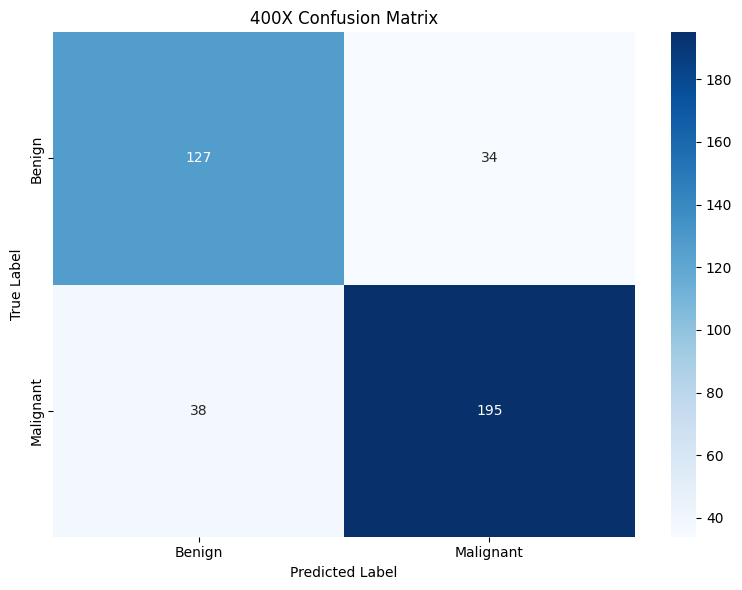


🔬 Training on All magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Epoch   1: Train Loss: 0.1432, Val Loss: 0.1237, Val AUC: 0.8847


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   2: Train Loss: 0.1335, Val Loss: 0.1162, Val AUC: 0.8738


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   3: Train Loss: 0.1264, Val Loss: 0.1017, Val AUC: 0.8799


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   4: Train Loss: 0.1220, Val Loss: 0.1001, Val AUC: 0.8941


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch   5: Train Loss: 0.1267, Val Loss: 0.1382, Val AUC: 0.8364


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch   6: Train Loss: 0.1184, Val Loss: 0.1192, Val AUC: 0.8529


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch   7: Train Loss: 0.1260, Val Loss: 0.1195, Val AUC: 0.8843


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch   8: Train Loss: 0.1198, Val Loss: 0.1164, Val AUC: 0.8558


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch   9: Train Loss: 0.1211, Val Loss: 0.1271, Val AUC: 0.8893


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch  10: Train Loss: 0.1193, Val Loss: 0.1169, Val AUC: 0.8749


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch  11: Train Loss: 0.1204, Val Loss: 0.1263, Val AUC: 0.8966


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch  12: Train Loss: 0.1159, Val Loss: 0.1278, Val AUC: 0.8576


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch  13: Train Loss: 0.1217, Val Loss: 0.1194, Val AUC: 0.8893


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Epoch  14: Train Loss: 0.1208, Val Loss: 0.1030, Val AUC: 0.8921


Training:  83%|████████▎ | 120/145 [01:26<00:11,  2.22it/s, Loss=0.1072]

In [ ]:
if __name__ == "__main__":
    results = main()
